In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import numpy as np
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F

# Remove all the warnings
import warnings
warnings.filterwarnings('ignore')

# Set env CUDA_LAUNCH_BLOCKING=1
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Retina display
%config InlineBackend.figure_format = 'retina'

try:
    from einops import rearrange
except ImportError:
    %pip install einops
    from einops import rearrange

In [ ]:
if os.path.exists('dog.jpg'):
    print('dog.jpg exists')
else:
    !wget https://segment-anything.com/assets/gallery/AdobeStock_94274587_welsh_corgi_pembroke_CD.jpg -O dog.jpg

dog.jpg exists


In [3]:
# Read in a image from torchvision
img = torchvision.io.read_image("C:\\Users\\KIIT\\Pictures\\premium_photo-1669748157617-a3a83cc8ea23.jpg")
print(img.shape)

torch.Size([3, 2002, 3000])


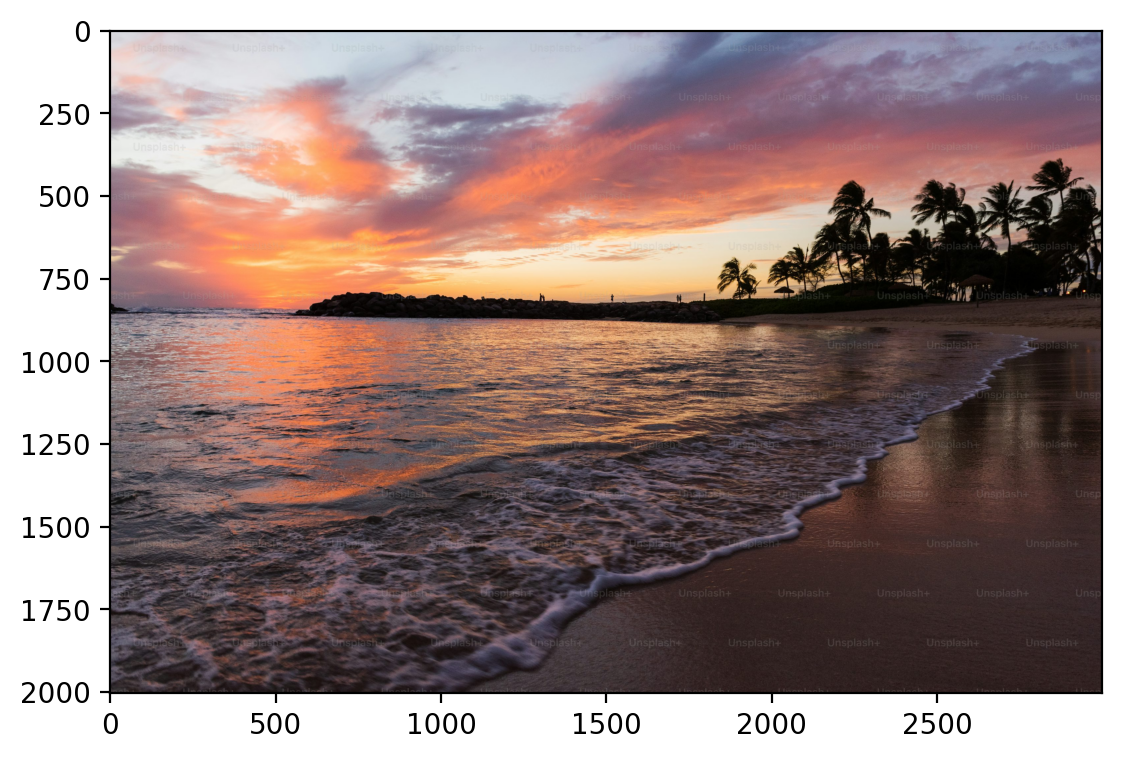

In [4]:
plt.imshow(rearrange(img, 'c h w -> h w c').numpy())


In [5]:
from sklearn import preprocessing

scaler_img = preprocessing.MinMaxScaler().fit(img.reshape(-1, 1))
scaler_img

MinMaxScaler()

In [6]:
img_scaled = scaler_img.transform(img.reshape(-1, 1)).reshape(img.shape)
img_scaled.shape

img_scaled = torch.tensor(img_scaled)

In [7]:
img_scaled = img_scaled.to(device)
img_scaled

tensor([[[0.8510, 0.8510, 0.8510,  ..., 0.4706, 0.4784, 0.4784],
         [0.8510, 0.8510, 0.8549,  ..., 0.4745, 0.4784, 0.4745],
         [0.8510, 0.8549, 0.8549,  ..., 0.4863, 0.4784, 0.4745],
         ...,
         [0.3529, 0.3451, 0.3490,  ..., 0.1961, 0.1765, 0.1725],
         [0.3059, 0.3255, 0.3216,  ..., 0.2000, 0.1961, 0.1843],
         [0.2980, 0.3255, 0.3098,  ..., 0.2000, 0.1961, 0.1843]],

        [[0.8471, 0.8471, 0.8471,  ..., 0.5451, 0.5412, 0.5412],
         [0.8471, 0.8471, 0.8510,  ..., 0.5490, 0.5412, 0.5373],
         [0.8471, 0.8510, 0.8510,  ..., 0.5490, 0.5412, 0.5373],
         ...,
         [0.3098, 0.3098, 0.3059,  ..., 0.1333, 0.1137, 0.1098],
         [0.2706, 0.3020, 0.2863,  ..., 0.1373, 0.1333, 0.1216],
         [0.2745, 0.3020, 0.2863,  ..., 0.1373, 0.1333, 0.1216]],

        [[0.8667, 0.8667, 0.8667,  ..., 0.6706, 0.6706, 0.6706],
         [0.8667, 0.8667, 0.8706,  ..., 0.6745, 0.6706, 0.6667],
         [0.8667, 0.8706, 0.8706,  ..., 0.6784, 0.6706, 0.

In [54]:
# crop200 = torchvision.transforms.functional.crop(img_scaled.cpu(), 800, 1000, 200, 200)
# crop200.shape

torch.Size([3, 200, 200])

In [12]:
crop400= torchvision.transforms.functional.crop(img_scaled.cpu(), 800, 1000, 400, 400)
crop400.shape

torch.Size([3, 400, 400])

In [16]:
import torch.nn.functional as F

# Assuming crop400 is already a tensor with shape [3, 400, 400]
crop200_tensor = F.interpolate(crop400.unsqueeze(0), size=(200, 200), mode='bilinear', align_corners=False)

# Remove the batch dimension after resizing
crop200 = crop200_tensor.squeeze(0)

# Check the shape of the resized tensor
print(crop200.shape)  # Should output torch.Size([3, 200, 200])


torch.Size([3, 200, 200])


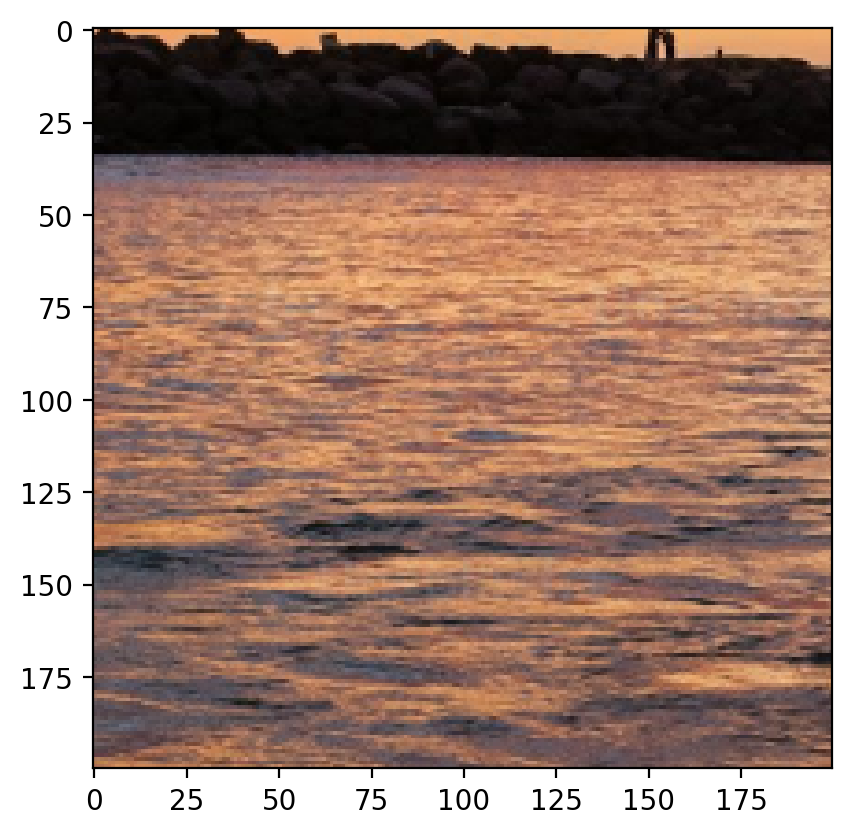

In [17]:
plt.imshow(rearrange(crop200, 'c h w -> h w c').cpu().numpy())


In [7]:
# crop = torchvision.transforms.functional.crop(img_scaled.cpu(), 600, 800, 300, 300)
# crop.shape

torch.Size([3, 300, 300])

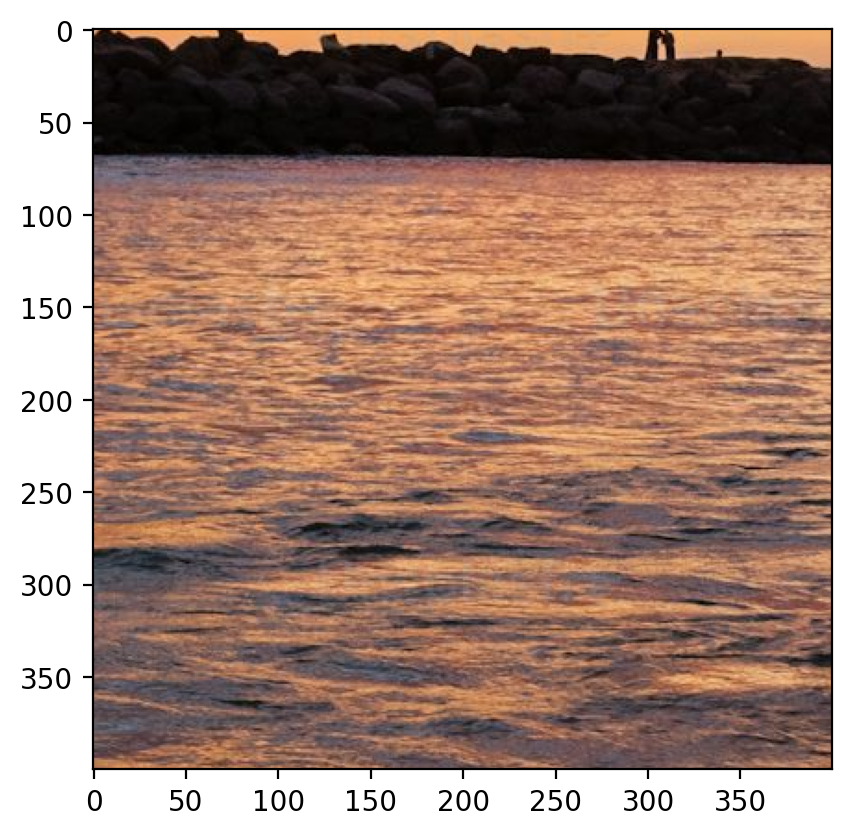

In [13]:
plt.imshow(rearrange(crop400, 'c h w -> h w c').cpu().numpy())


In [18]:
# crop = crop.to(device)
crop200 = crop200.to(device)



In [19]:
# # Get the dimensions of the image tensor
# num_channels, height, width = crop.shape
# print(num_channels, height, width)
# Get the dimensions of the image tensor
num_channels, height, width = crop200.shape
print(num_channels, height, width)

3 200 200


In [20]:
num_channels, height, width = 2, 3, 4


# Create a 2D grid of (x,y) coordinates
w_coords = torch.arange(width).repeat(height, 1)
h_coords = torch.arange(height).repeat(width, 1).t()
w_coords = w_coords.reshape(-1)
h_coords = h_coords.reshape(-1)

# Combine the x and y coordinates into a single tensor
X = torch.stack([h_coords, w_coords], dim=1).float()

In [21]:
X.shape

torch.Size([12, 2])

In [22]:
def create_coordinate_map(img):
    """
    img: torch.Tensor of shape (num_channels, height, width)

    return: tuple of torch.Tensor of shape (height * width, 2) and torch.Tensor of shape (height * width, num_channels)
    """

    num_channels, height, width = img.shape

    # Create a 2D grid of (x,y) coordinates (h, w)
    # width values change faster than height values
    w_coords = torch.arange(width).repeat(height, 1)
    h_coords = torch.arange(height).repeat(width, 1).t()
    w_coords = w_coords.reshape(-1)
    h_coords = h_coords.reshape(-1)

    # Combine the x and y coordinates into a single tensor
    X = torch.stack([h_coords, w_coords], dim=1).float()

    # Move X to GPU if available
    X = X.to(device)

    # Reshape the image to (h * w, num_channels)
    Y = rearrange(img, 'c h w -> (h w) c').float()
    return X, Y

In [23]:
# dog_X, dog_Y = create_coordinate_map(crop)

# dog_X.shape, dog_Y.shape

dog_X2, dog_Y2 = create_coordinate_map(crop200)

dog_X2.shape, dog_Y2.shape

(torch.Size([40000, 2]), torch.Size([40000, 3]))

200 image

In [24]:
# MinMaxScaler from -1 to 1
scaler_X = preprocessing.MinMaxScaler(feature_range=(-1, 1)).fit(dog_X2.cpu())

# Scale the X coordinates
dog_X_scaled2 = scaler_X.transform(dog_X2.cpu())

# Move the scaled X coordinates to the GPU
dog_X_scaled2 = torch.tensor(dog_X_scaled2).to(device)

# Set to dtype float32
dog_X_scaled2= dog_X_scaled2.float()

400 image

In [25]:
dog_X4, dog_Y4 = create_coordinate_map(crop400)

print(dog_X4.shape, dog_Y4.shape)

# MinMaxScaler from -1 to 1
scaler_X = preprocessing.MinMaxScaler(feature_range=(-1, 1)).fit(dog_X2.cpu())

# Scale the X coordinates
dog_X_scaled4 = scaler_X.transform(dog_X4.cpu())

# Move the scaled X coordinates to the GPU
dog_X_scaled4 = torch.tensor(dog_X_scaled4).to(device)

# Set to dtype float32
dog_X_scaled4= dog_X_scaled4.float()

torch.Size([160000, 2]) torch.Size([160000, 3])


In [26]:
class LinearModel(nn.Module):
    def __init__(self, in_features, out_features):
        super(LinearModel, self).__init__()
        self.linear = nn.Linear(in_features, out_features)

    def forward(self, x):
        return self.linear(x)


In [27]:
net = LinearModel(2, 3)
net.to(device)


LinearModel(
  (linear): Linear(in_features=2, out_features=3, bias=True)
)

In [28]:
def train(net, lr, X, Y, epochs, verbose=True):
    """
    net: torch.nn.Module
    lr: float
    X: torch.Tensor of shape (num_samples, 2)
    Y: torch.Tensor of shape (num_samples, 3)
    """

    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    for epoch in range(epochs):
        optimizer.zero_grad()
        outputs = net(X)


        loss = criterion(outputs, Y)
        loss.backward()
        optimizer.step()
        if verbose and epoch % 100 == 0:
            print(f"Epoch {epoch} loss: {loss.item():.6f}")
    return loss.item()

In [29]:
train(net, 0.01, dog_X_scaled2, dog_Y2, 1000)

Epoch 0 loss: 0.802390
Epoch 100 loss: 0.051687
Epoch 200 loss: 0.036958
Epoch 300 loss: 0.036941
Epoch 400 loss: 0.036941
Epoch 500 loss: 0.036941
Epoch 600 loss: 0.036941
Epoch 700 loss: 0.036941
Epoch 800 loss: 0.036941
Epoch 900 loss: 0.036941


0.036940738558769226

In [30]:
def plot_reconstructed_and_original_image(original_img, net, X, title=""):
    """
    net: torch.nn.Module
    X: torch.Tensor of shape (num_samples, 2)
    Y: torch.Tensor of shape (num_samples, 3)
    """
    num_channels, height, width = original_img.shape
    net.eval()
    with torch.no_grad():
        outputs = net(X)
        outputs = outputs.reshape(height, width, num_channels)
        #outputs = outputs.permute(1, 2, 0)
    fig = plt.figure(figsize=(6, 4))
    gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1])

    ax0 = plt.subplot(gs[0])
    ax1 = plt.subplot(gs[1])

    ax0.imshow(outputs.cpu())
    ax0.set_title("Reconstructed Image")


    ax1.imshow(original_img.cpu().permute(1, 2, 0))
    ax1.set_title("Original Image")

    for a in [ax0, ax1]:
        a.axis("off")


    fig.suptitle(title, y=0.9)
    plt.tight_layout()

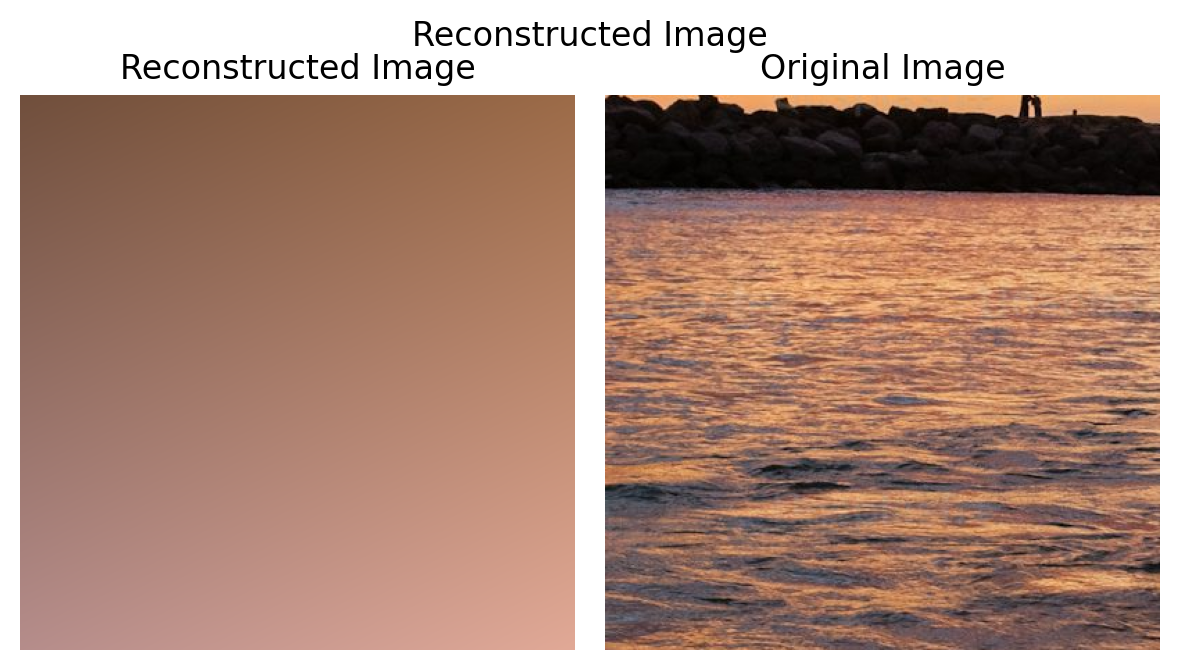

In [31]:
plot_reconstructed_and_original_image(crop400, net, dog_X_scaled4, title="Reconstructed Image")

In [32]:
# create RFF features
def create_rff_features(X, num_features, sigma):
    from sklearn.kernel_approximation import RBFSampler
    rff = RBFSampler(n_components=num_features, gamma=1/(2 * sigma**2))
    X = X.cpu().numpy()
    X = rff.fit_transform(X)
    return torch.tensor(X, dtype=torch.float32).to(device)

In [39]:
X_rff2 = create_rff_features(dog_X_scaled2, 10000, 0.008)

In [40]:
X_rff4 = create_rff_features(dog_X_scaled4, 10000, 0.008)

In [41]:
X_rff2.shape

torch.Size([40000, 10000])

In [42]:
X_rff4.shape

torch.Size([160000, 10000])

In [43]:
net = LinearModel(X_rff2.shape[1], 3)
net.to(device)

train(net, 0.005, X_rff2, dog_Y2, 500)

Epoch 0 loss: 0.230611
Epoch 100 loss: 0.035350
Epoch 200 loss: 0.023106
Epoch 300 loss: 0.020091
Epoch 400 loss: 0.017888


0.016150429844856262

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.012061248..1.4110907].


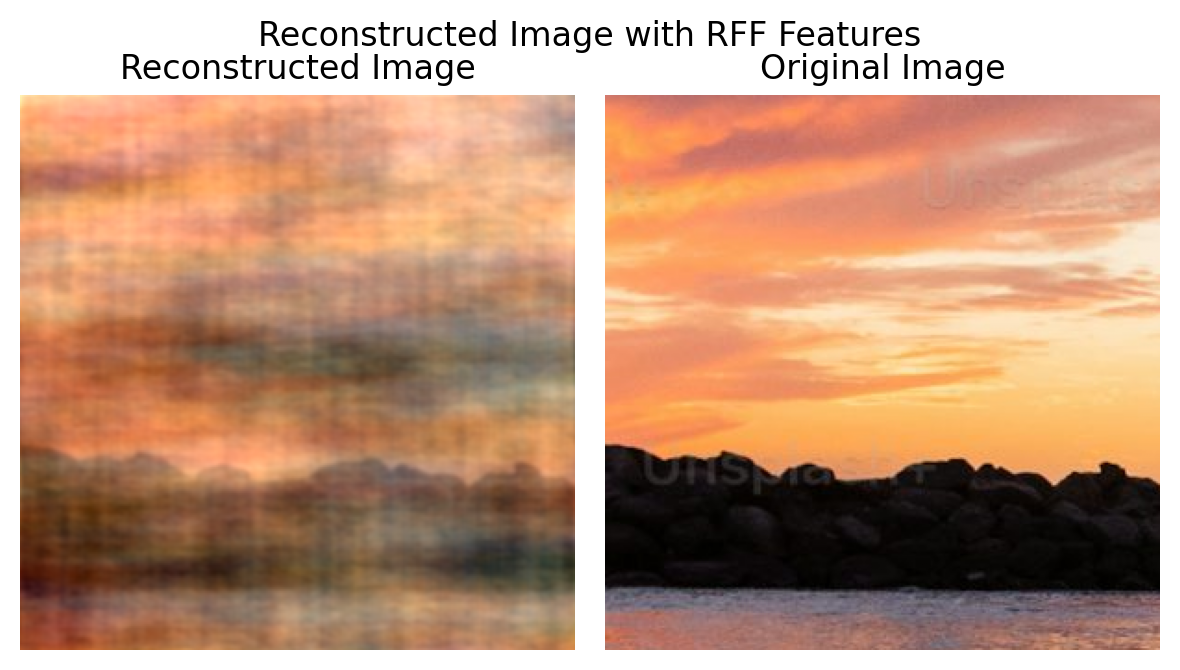

In [34]:
# plot_reconstructed_and_original_image(crop400, net, X_rff4, title="Reconstructed Image with RFF Features")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.97025836..1.9353578].


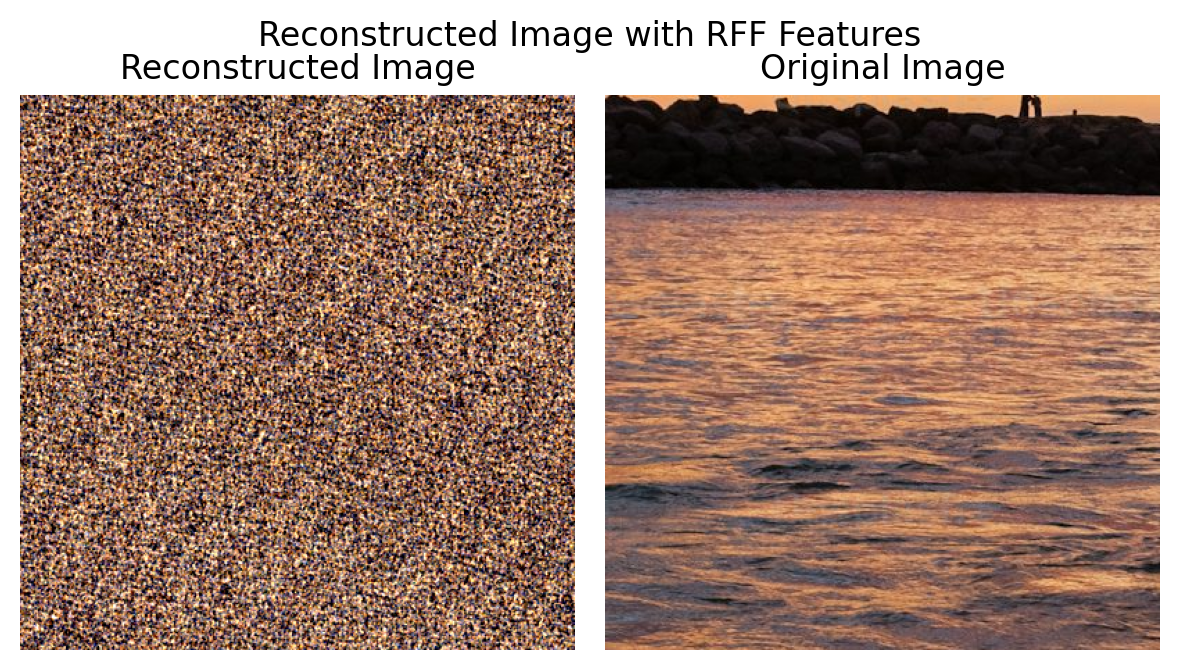

In [44]:
plot_reconstructed_and_original_image(crop400, net, X_rff4, title="Reconstructed Image with RFF Features")

In [ ]:
w = 100
scale=2
torch.arange(0, w, 1/scale)

tensor([ 0.0000,  0.5000,  1.0000,  1.5000,  2.0000,  2.5000,  3.0000,  3.5000,
         4.0000,  4.5000,  5.0000,  5.5000,  6.0000,  6.5000,  7.0000,  7.5000,
         8.0000,  8.5000,  9.0000,  9.5000, 10.0000, 10.5000, 11.0000, 11.5000,
        12.0000, 12.5000, 13.0000, 13.5000, 14.0000, 14.5000, 15.0000, 15.5000,
        16.0000, 16.5000, 17.0000, 17.5000, 18.0000, 18.5000, 19.0000, 19.5000,
        20.0000, 20.5000, 21.0000, 21.5000, 22.0000, 22.5000, 23.0000, 23.5000,
        24.0000, 24.5000, 25.0000, 25.5000, 26.0000, 26.5000, 27.0000, 27.5000,
        28.0000, 28.5000, 29.0000, 29.5000, 30.0000, 30.5000, 31.0000, 31.5000,
        32.0000, 32.5000, 33.0000, 33.5000, 34.0000, 34.5000, 35.0000, 35.5000,
        36.0000, 36.5000, 37.0000, 37.5000, 38.0000, 38.5000, 39.0000, 39.5000,
        40.0000, 40.5000, 41.0000, 41.5000, 42.0000, 42.5000, 43.0000, 43.5000,
        44.0000, 44.5000, 45.0000, 45.5000, 46.0000, 46.5000, 47.0000, 47.5000,
        48.0000, 48.5000, 49.0000, 49.50

In [ ]:
def create_coordinate_map(img, scale=1):
    """
    img: torch.Tensor of shape (num_channels, height, width)

    return: tuple of torch.Tensor of shape (height * width, 2) and torch.Tensor of shape (height * width, num_channels)
    """

    num_channels, height, width = img.shape

    # Create a 2D grid of (x,y) coordinates (h, w)
    # width values change faster than height values
    w_coords = torch.arange(0, width,  1/scale).repeat(int(height*scale), 1)
    h_coords = torch.arange(0, height, 1/scale).repeat(int(width*scale), 1).t()
    w_coords = w_coords.reshape(-1)
    h_coords = h_coords.reshape(-1)

    # Combine the x and y coordinates into a single tensor
    X = torch.stack([h_coords, w_coords], dim=1).float()

    # Move X to GPU if available
    X = X.to(device)

    # Reshape the image to (h * w, num_channels)
    Y = rearrange(img, 'c h w -> (h w) c').float()
    return X, Y

In [ ]:
create_coordinate_map(crop, scale=2)[0].shape


torch.Size([360000, 2])

In [ ]:
create_coordinate_map(crop, scale=1)[0].shape

torch.Size([90000, 2])